# Museums in the Pandemic - Extract indicators

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Extract indicators from museum text.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [16]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import random
import spacy
from termcolor import colored
import sys
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
from datetime import datetime
import seaborn as sns
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations
from scrapers.scraper_websites import get_scraping_session_tables, get_session_id_from_table_name
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks_py
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [3]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

def get_all_sessions():
    return sorted([get_session_id_from_table_name(x) for x in get_scraping_session_tables(db_conn)])

DB connected


## Extract matches for all museums

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

The manual annotation data with 700 cases is in `matches_valid_ann_df_v3.pik`.

### Load deep learning validation model

In [4]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def remove_duplicate_matches(df):
    # find duplicates
    n = len(df)
    df = df.drop_duplicates(subset=df.columns.difference(['page_id','sentence_id']))
    print('remove_duplicate_matches:',n,len(df))
    return df

def prep_match_data(df):
    for c in valid_model_columns:
        if not c in df.columns:
            print("Warning: column '{}' is missing, adding a zero column".format(c))
            df[c] = 0
    
    df = remove_duplicate_matches(df)
    df = df[valid_model_columns]
    assert len(df.columns) == 33, len(df.columns)
    num_df = df.select_dtypes(include=[np.number])
    scaler = MinMaxScaler()
    # fit and transform in one step
    cols = num_df.columns
    x_data = pd.DataFrame(scaler.fit_transform(num_df),columns=cols)
    return x_data

def convert_pred_to_bool(vals):
    pred_y = (vals > 0.5).astype("bool")
    # unpack results
    bool_vals = [item for sublist in pred_y for item in sublist]
    return bool_vals

In [5]:
# MODEL COLUMNS
cols_fn = out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model_columns.csv"
valid_model_columns = pd.read_csv(cols_fn).iloc[:, 0].tolist()

valid_ann_df_fn = 'matches_valid_ann_df_v3.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

valid_match_cnn_model = load_model(out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model.h5")
valid_match_cnn_model

x_data = prep_match_data(valid_ann_df)
assert len(x_data.columns) == 33, len(x_data.columns)
print(x_data)
pred_valid = convert_pred_to_bool(valid_match_cnn_model.predict(x_data))

valid_ann_df['predicted_valid'] = pred_valid

#valid_ann_df.to_excel(out_folder+"tmp/check_deeplearning.xlsx",index=False)
valid_ann_df.sample(5)

2021-11-18 10:18:25.520617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


remove_duplicate_matches: 700 700
     sem_similarity   token_n   lemma_n  ann_overlap_lemma  ann_overlap_token  \
0          0.659748  0.285714  0.166667           1.000000            1.00000   
1          0.703680  0.428571  0.333333           0.733333            0.75000   
2          0.759582  0.000000  0.000000           0.146667            0.00000   
3          0.726219  0.571429  0.500000           0.644448            0.66667   
4          0.667261  0.000000  0.000000           0.200000            0.00000   
..              ...       ...       ...                ...                ...   
695        0.830129  0.428571  0.333333           0.573333            0.60000   
696        0.712849  0.142857  0.166667           1.000000            0.50000   
697        0.398828  0.000000  0.000000           0.200000            0.00000   
698        0.647905  0.000000  0.000000           0.200000            0.00000   
699        0.661403  0.142857  0.000000           0.288885            0.333

2021-11-18 10:18:25.807804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,muse_id,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,page_tokens,sem_similarity,token_n,...,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_restruct,indicator_code_staff_working,overlap_bin,valid_match,valid_match_b,predicted_valid
358,mm.ace.1116,664564,mus_page664564_sent00042,ann_ex_00007,closed_cur,20210304,to close doors,coronavirus covid-19 medical museum will close...,0.6527,0,...,0,0,0,0,0,0,"(0.0, 0.45]",T,True,False
118,mm.MDN.026,292710,mus_page292710_sent00344,ann_ex_00076,funding_fundraise,20210304,survival appeal,visa appeals student complaints student discip...,0.4784,0,...,0,0,0,0,0,0,"(0.45, 1.01]",F,False,False
128,mm.wiki.295,115332,mus_page115332_sent00032,ann_ex_00029,closed_cur,20210304,museum closed tier national lockdown restrictions,only house england designed charles rennie mac...,0.6735,2,...,0,0,0,0,0,0,"(0.0, 0.45]",T,True,True
219,mm.domus.NW048,549983,mus_page549983_sent00006,ann_ex_00270,staff_working,20210304,museum will continue to monitor government gui...,otherwise we 'll assume you ok to continue,0.7787,2,...,0,0,0,0,0,1,"(0.0, 0.45]",F,False,True
289,mm.domus.SW131,721779,mus_page721779_sent00066,ann_ex_00204,open_onlineshop,20210304,our online shop remains open,save your next online shop purchase,0.8561,2,...,0,0,0,0,0,0,"(0.0, 0.45]",T,True,True


In [5]:
def aggr_indicators_by_indic(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

# extract indicator stats
#indf2 = valid_ann_df.indicator_code.value_counts().to_frame('valid_set_700_cases')
#indf2['indicator_code'] = indf2.index
#indf2

indf2 = pd.DataFrame()
for indic,subdf in valid_ann_df.groupby('indicator_code'):
    indf2 = indf2.append(aggr_indicators_by_indic(subdf))
indf2 = indf2.round(3)
indf2

/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

,indicator_code,cases_700,precision,recall,fscore,tn,fp,fn,tp
0,closed_cur,83,0.886,0.705,0.785,0.422,0.048,0.157,0.373
0,closed_indef,22,0.889,0.889,0.889,0.545,0.045,0.045,0.364
0,closed_perm,4,0.000,0.000,0.000,NaN,NaN,NaN,NaN
0,finance_health,7,1.000,1.000,1.000,0.714,0.000,0.000,0.286
0,funding_did_not_get,21,0.000,0.000,0.000,0.952,0.000,0.048,0.000
0,funding_fundraise,74,0.909,0.357,0.513,0.608,0.014,0.243,0.135
0,funding_gov_emer,19,1.000,0.500,0.667,0.895,0.000,0.053,0.053
0,funding_other_emer,2,0.000,0.000,0.000,NaN,NaN,NaN,NaN
0,lang_difficulty,67,1.000,0.125,0.222,0.881,0.000,0.104,0.015
0,made_covid_safe,5,0.000,0.000,0.000,0.800,0.000,0.200,0.000


### Load all matches from DB (slow)

- Dump all matches from DB, after running `an_text` on ALL museums for a given crawling session.

In [6]:
# DB columns:
""" 
example_id indicator_code lemma_n lemma_n_wdupl token_n token_n_wdupl criticalwords_n criticalwords_n_wdupl sentence_id  sent_len
example_len example_crit_len ann_overlap_lemma ann_overlap_token ann_overlap_criticwords txt_overlap_lemma
txt_overlap_token ann_ex_tokens ann_ex_tokens page_tokens session_id page_id muse_id keep_stopwords
"""
sessions = get_all_sessions()
sessions = ['20210304','20210404','20210914'] # DEBUG
print("target sessions:", sessions)

# get all sessions from DB (slow)
if True: # debug
    for session_id in sessions:
        get_all_matches_from_db(session_id, db_conn, out_folder)

target sessions: ['20210304', '20210404', '20210914']
get_all_matches_from_db 20210304
query results: (1136440, 17)
	saved ../../tmp/matches_dump_df_20210304.pik
get_all_matches_from_db 20210404
query results: (842167, 17)
	saved ../../tmp/matches_dump_df_20210404.pik
get_all_matches_from_db 20210914
query results: (314209, 17)
	saved ../../tmp/matches_dump_df_20210914.pik


## Predict and save valid matches

Dump results in file `../../tmp/all_valid_matches_dump_df.pik`

In [7]:
#sessions = ['20210304','20210404']

def select_and_merge_indicators(df):
    """ based on `indicator_code_stats_validation-v2.xlsx` """
    print('select_and_merge_indicators',df.shape)
    # drop invalid indicators
    invalid_indics = ['closed_perm','finance_health','funding_did_not_get',
                     'funding_other_emer','lang_difficulty','made_covid_safe',
                     'open_cafe','open_onlineshop','project_postpone',
                      'staff_hiring','staff_restruct']
    vdf = df[~df['indicator_code'].isin(invalid_indics)].copy()
    
    # merge indicators
    merged_indic = {'online_event':'online_engag',
                    'online_exhib':'online_engag',
                    'reopen_plan':'reopen_intent',
                    'funding_fundraise':'funding',
                    'funding_gov_emer':'funding',
                    'closed_indef':'closed_cur'}
    indicator_code_merged = vdf['indicator_code'].replace(merged_indic)
    vdf.loc[:,['indicator_code_merged']]=indicator_code_merged
    # compare results
    print(df['indicator_code'].value_counts())
    print(vdf['indicator_code_merged'].value_counts())
    print('  select_and_merge_indicators filtered:',vdf.shape)
    return vdf

def select_valid_matches(df, model):
    """ use Deep Learning model to validate matches """
    x_data = prep_match_data(df)
    
    print('select_valid_matches', x_data.shape)
    # check column order
    assert valid_model_columns == x_data.columns.tolist()
    print(x_data.shape)
    # apply model for predictions
    valid_int = model.predict(x_data)
    pred_valid = convert_pred_to_bool(valid_int)
    #print(type(pred_valid),len(pred_valid))
    df['valid_match'] = pred_valid
    print(df.valid_match.value_counts())
    return df

assert len(valid_model_columns) > 0
allsess_match_df = pd.DataFrame(columns=valid_model_columns)

print('sessions:', sessions)
for session_id in sessions:
    print('\n> session_id',session_id)
    matches_fn = out_folder+'tmp/matches_dump_df_{}.pik'.format(session_id)
    matchdf = pd.read_pickle(matches_fn)
    matchdf = remove_duplicate_matches(matchdf)
    #matchdf = matchdf.sample(100) # DEBUG
    print("\t", matches_fn, matchdf.shape)
    # apply model to get valid matches
    validmatch_df = select_valid_matches(matchdf, valid_match_cnn_model)
    # save sample to inspect results
    #validmatch_df.sample(200).to_csv(out_folder+'tmp/valid_matches_sample_{}.tsv'.format(session_id),sep='\t')
    # save results
    allsess_match_df = pd.concat([allsess_match_df, validmatch_df])
    del validmatch_df

allsess_match_df2 = select_and_merge_indicators(allsess_match_df)
allsess_match_df2 = remove_duplicate_matches(allsess_match_df2)
all_vmatches_fn = out_folder+'tmp/all_valid_matches_dump_df.pik'
print("valid matches vs invalid\n", allsess_match_df2.valid_match.value_counts())
print("sessions\n", allsess_match_df2.session_id.value_counts())
valdf = allsess_match_df2[allsess_match_df2.valid_match]
valdf.to_pickle(all_vmatches_fn)
print('valid matches for all sessions:', len(valdf), all_vmatches_fn)

sessions: ['20210304', '20210404', '20210914']
> session_id 20210304
remove_duplicate_matches: 1136440 926928
	 ../../tmp/matches_dump_df_20210304.pik (926928, 41)
remove_duplicate_matches: 926928 926928
select_valid_matches (926928, 33)
(926928, 33)
False    842258
True      84670
Name: valid_match, dtype: int64
> session_id 20210404
remove_duplicate_matches: 842167 729944
	 ../../tmp/matches_dump_df_20210404.pik (729944, 40)
remove_duplicate_matches: 729944 729944
select_valid_matches (729944, 33)
(729944, 33)
False    659234
True      70710
Name: valid_match, dtype: int64
> session_id 20210914
remove_duplicate_matches: 314209 293662
	 ../../tmp/matches_dump_df_20210914.pik (293662, 40)
remove_duplicate_matches: 293662 293662
select_valid_matches (293662, 33)
(293662, 33)
False    272812
True      20850
Name: valid_match, dtype: int64
select_and_merge_indicators (1950534, 42)
reopen_intent          343907
funding_fundraise      271908
closed_cur             246199
lang_difficulty    

In [35]:
print(allsess_match_df.columns)
print("Matches from DB:")
round(allsess_match_df['valid_match'].value_counts()/len(allsess_match_df),2)

Index(['sem_similarity', 'token_n', 'lemma_n', 'ann_overlap_lemma',
       'ann_overlap_token', 'example_len', 'txt_overlap_lemma',
       'txt_overlap_token', 'ann_overlap_criticwords', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'txt_overlap_tokenlemma',
       'indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_made_covid_safe', 'indicator_code_online_engag',
       'indicator_code_online_event', 'indicator_code_online_exhib',
       'indicator_code_open_cafe', 'indicator_code_open_cur',
       'indicator_code_open_onlineshop', 'indicator_code_project_postpone',
       'indicator_code_reopen_intent', 'indicator_code_reopen_plan',
       'indicator_code_staff_hiring', 'indicator_code_staff_restruct',
       'indicator

False    0.88
True     0.12
Name: valid_match, dtype: float64

## Aggregate indicators for extra evaluation

### Basic stats

In [9]:
assert len(allsess_match_df) > 0
allsess_match_valid_df = allsess_match_df[allsess_match_df.valid_match]
allsess_match_valid_df = remove_duplicate_matches(allsess_match_valid_df)
print("N =", len(allsess_match_valid_df))
print("N museums =", len(allsess_match_valid_df.muse_id.unique()))
allsess_match_valid_df.head(100)

remove_duplicate_matches: 155380 155380
N = 155380
N museums = 2912


,sem_similarity,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,...,indicator_code_staff_working,muse_id,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,page_tokens,valid_match
12,0.6864,2.0,2.0,0.25000,0.25000,8,0.40000,0.40000,1.00000,2.0,...,0,mm.domus.SE118,16207.0,mus_page16207_sent00004,ann_ex_00222,reopen_intent,20210304,we will constantly monitor situation look to r...,museum plans to reopen july,True
13,0.7522,1.0,1.0,0.33333,0.33333,3,0.20000,0.20000,1.00000,1.0,...,0,mm.domus.SE118,16207.0,mus_page16207_sent00004,ann_ex_00223,reopen_intent,20210304,we can reopen,museum plans to reopen july,True
14,0.7469,1.0,1.0,0.25000,0.25000,4,0.20000,0.20000,1.00000,1.0,...,0,mm.domus.SE118,16207.0,mus_page16207_sent00004,ann_ex_00234,reopen_intent,20210304,will reopen fully in,museum plans to reopen july,True
15,0.8012,1.0,1.0,0.50000,0.50000,2,0.20000,0.20000,1.00000,1.0,...,0,mm.domus.SE118,16207.0,mus_page16207_sent00004,ann_ex_00244,reopen_intent,20210304,will reopen,museum plans to reopen july,True
17,0.7956,2.0,3.0,0.60000,0.40000,5,0.60000,0.40000,1.00000,3.0,...,0,mm.domus.SE118,16207.0,mus_page16207_sent00004,ann_ex_00254,reopen_plan,20210304,we plan to reopen season,museum plans to reopen july,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,0.6732,1.0,1.0,0.25000,0.25000,4,0.05556,0.05556,1.00000,1.0,...,0,mm.domus.EM073,11350.0,mus_page11350_sent00024,ann_ex_00034,closed_cur,20210304,museum currently closed restrictions,events volunteer house interpretation voluntee...,True
1032,0.6408,2.0,2.0,0.66667,0.66667,3,0.11111,0.11111,0.66667,2.0,...,0,mm.domus.EM073,11350.0,mus_page11350_sent00024,ann_ex_00041,closed_indef,20210304,closed further notice,events volunteer house interpretation voluntee...,True
1033,0.7288,2.0,2.0,0.50000,0.50000,4,0.11111,0.11111,0.50000,2.0,...,0,mm.domus.EM073,11350.0,mus_page11350_sent00024,ann_ex_00042,closed_indef,20210304,museum closed further notice,events volunteer house interpretation voluntee...,True
1035,0.7728,2.0,2.0,0.50000,0.50000,4,0.11111,0.11111,0.50000,2.0,...,0,mm.domus.EM073,11350.0,mus_page11350_sent00024,ann_ex_00197,open_cur,20210304,now open careful visitors,events volunteer house interpretation voluntee...,True


In [10]:
# load annotations
indic_df, ann_df = get_indicator_annotations(out_folder)
del indic_df
# calculate n_indic_all_ann_examples
ann_stats_df = ann_df.groupby(['indicator_code']).size().reset_index(name='n_indic_all_ann_examples')
print(ann_df.head(30))
ann_stats_df

      example_id                                       text_phrases  \
1   ann_ex_00002  closed to members of the public until further ...   
2   ann_ex_00003                       closed until further notice    
5   ann_ex_00006  currently we are closed due to Covid restricti...   
6   ann_ex_00007                                 had to close doors   
10  ann_ex_00011  there will be no services over due to the Covi...   
15  ann_ex_00016  currently closed due to Government Covid restr...   
16  ann_ex_00017                     our office wil not reopen till   
17  ann_ex_00018                         is now closed due to covid   
19  ann_ex_00020  We have made the decision to remain closed to ...   
21  ann_ex_00022  we have taken the hard decision to remain clos...   
22  ann_ex_00023   we have taken the hard decision to remain closed   
23  ann_ex_00024        will be closed during the national lockdown   
24  ann_ex_00025  currently closed in line with Government restr...   
25  an

,indicator_code,n_indic_all_ann_examples
0,closed_cur,21
1,closed_indef,4
2,closed_perm,4
3,finance_health,6
4,funding_did_not_get,7
5,funding_fundraise,45
6,funding_gov_emer,11
7,funding_other_emer,4
8,lang_difficulty,37
9,made_covid_safe,1


### Calculate precision of matching by indicator

This is to evaluate the performance by indicator to account for the high variability, as suggested by AP. 

- The results are in `indicator_code_stats_validation-v1.xlsx`. 
- Some indicators were removed.
- An extra evaluation was designed.

In [11]:
# get indicator stats

def aggr_indicators_by_indic_allmatches(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['matches_ml_true'] = len(df)
    d['matches_ml_tot'] = len(allsess_match_df)
    d['matches_ml_pc'] = round(d['matches_ml_true'] / d['matches_ml_tot'],3)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

In [ ]:
indf3 = pd.DataFrame()
for indic,subdf in allsess_match_df.groupby('indicator_code'):
    indf3 = indf3.append(aggr_indicators_by_indic_allmatches(subdf))

indf3 = indf3.reset_index()
indf3 = indf3.merge(indf2,on='indicator_code',how='outer')
indf3 = indf3.merge(ann_stats_df,on='indicator_code',how='outer')
indf3.to_excel(out_folder+'tmp/indicator_code_stats_validation.xlsx',index=False)
indf3

Aggregate indicator stats by sentence.

In [ ]:
col_aggr = ['muse_id','session_id','page_id','indicator_code','n_indic_all_ann_examples']

def aggr_indicators_sent(df):
    d = {}
    for c in col_aggr:
        d[c] = df[c].tolist()[0]
    d['n_uniq_sentences'] = df['sentence_id'].nunique()
    d['n_matched_annotations'] = df['example_id'].nunique()
    d['n_matches'] = len(df)
    d['matches_to_sent_ratio'] = round(d['n_matches'] / d['n_uniq_sentences'],3)
    d['matches_to_example_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    #d['matches_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    return pd.Series(d)

n = len(allsess_match_valid_df)
allsess_match_valid_df2 = allsess_match_valid_df.merge(ann_stats_df, on='indicator_code')
assert n == len(allsess_match_valid_df2)

muse_indic_sent_df = allsess_match_valid_df2.groupby(col_aggr).apply(aggr_indicators_sent)
print(muse_indic_sent_df.columns)
muse_indic_sent_df.reset_index(drop=True, inplace=True)
muse_indic_sent_df = muse_indic_sent_df.sort_values(['session_id','muse_id','indicator_code'])
#print(muse_indic_sent_df.session_id.value_counts())
muse_indic_sent_df.to_excel(out_folder+'tmp/museum_indicators_sent_stats-v1.xlsx', index=False)
muse_indic_sent_df.head(30)

### Museum indic matches sample for extra validation - v1

Annotations done in `museum_website_match_sample10_summary-v1.xlsx`

In [ ]:
musem_sample_ids = muse_indic_sent_df.muse_id.sample(10,random_state=10)
muse_sample_df = muse_indic_sent_df[muse_indic_sent_df.muse_id.isin(musem_sample_ids)]
muse_sample_df.to_excel(out_folder+'tmp/museum_website_match_sample10_summary.xlsx',index=False)
allsess_match_valid_df[allsess_match_valid_df.muse_id.isin(musem_sample_ids)].to_excel(out_folder+'tmp/museum_website_match_sample10_matches.xlsx',index=False)

muse_sample_df

### Museum indic matches sample for extra validation - v2

- Select random sample from museums where matches > 0, 5 museums for 2 snapshots, for cases that need more investigation in `indicator_code_stats_validation-v1`
- Indicators to include: finance_health, lang_difficulty, staff_working
- Finance_health appears only in 2 museums, so we will discard it.
- The sample is in
  - `museum_website_match_sample5_lang_staff_summary-v1.xlsx`: stats for the 10 museums.
  - `museum_website_match_sample5_lang_staff-v1.xlsx`: sample of 200 detailed matches.
  
- The manual annotations are in `museum_website_match_sample5_lang_staff-v2.xlsx` and `museum_website_match_sample5_lang_staff_summary-v2.xlsx`.

In [35]:
assert len(allsess_match_valid_df) > 0
assert len(allsess_match_df) > 0

print('allsess_match_valid_df N =',len(allsess_match_valid_df))

df = allsess_match_valid_df[['muse_id','indicator_code']].drop_duplicates()
muse_indic_df = df['indicator_code'].value_counts()
print(muse_indic_df)
del df

random.seed(422)

res = pd.DataFrame()
res_all = pd.DataFrame()
for indic in ['lang_difficulty', 'staff_working']:
    print('\n>> indicator:', indic)
    mus_df = allsess_match_valid_df[allsess_match_valid_df['indicator_code'] == indic]
    mus_df2 = allsess_match_df[allsess_match_df['indicator_code'] == indic]
    mus_ids = random.sample(list(mus_df.muse_id.unique()), 5)
    print(mus_ids)
    # get sample for annotation
    sample_df = mus_df2[mus_df2.muse_id.isin(mus_ids)]
    print(len(sample_df))
    print(sample_df.valid_match.value_counts())
    #if indic == 'lang_difficulty':
    #    df1 = sample_df[sample_df.valid_match]
    #    neg_df = sample_df[sample_df.valid_match==False]
    #    print('XXX', len(neg_df), len(df1))
    #    df1.append(neg_df.sample(92))
    #else:
    df1 = sample_df.sample(100)
        
    res_all = res_all.append(sample_df)
    print('\nSample', len(df1), df1.valid_match.value_counts())
    print(df1['muse_id'].unique())
    print(df1['session_id'].unique())
    res = res.append(df1)
    del df1, mus_df2

# add stats
res_all = res_all.merge(ann_stats_df,on='indicator_code')

# generate detailed results
res.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff.xlsx',index=False)

allsess_match_valid_df N = 155380
online_engag           2622
reopen_intent          2268
closed_cur             2226
reopen_plan            1731
open_cur               1577
staff_working          1513
closed_indef           1341
funding_fundraise      1155
project_postpone        699
open_onlineshop         632
online_exhib            301
online_event            239
funding_gov_emer        128
lang_difficulty          80
funding_did_not_get      26
staff_hiring              3
funding_other_emer        2
staff_restruct            2
finance_health            2
made_covid_safe           2
Name: indicator_code, dtype: int64

>> indicator: lang_difficulty
['mm.aim.0981', 'mm.domus.SE566', 'mm.hud.005', 'mm.domus.SE475', 'mm.ace.042']
409
False    401
True       8
Name: valid_match, dtype: int64

Sample 100 False    98
True      2
Name: valid_match, dtype: int64
['mm.domus.SE475' 'mm.ace.042' 'mm.hud.005' 'mm.aim.0981' 'mm.domus.SE566']
['20210404' '20210304']

>> indicator: staff_working
[

ValueError: Sample larger than population or is negative

In [34]:
# generate summary
res_all
print(col_aggr)
df3 = res_all.groupby(col_aggr).apply(aggr_indicators_sent)
df3.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff_summary.xlsx',index=False)
del df3

NameError: name 'col_aggr' is not defined

#### Calculating precision of extra validation

In [ ]:
# load extra validation for language_difficulty and staff_working
vdf = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample5_lang_staff-v2.xlsx')
print(len(vdf))

vdf['predicted_valid'] = vdf.valid_match
vdf['valid_match_b'] = vdf['valid_PW'].map({'T': True, 'F': False})
vdf

In [ ]:
indf4 = pd.DataFrame()
for indic,df in vdf.groupby('indicator_code'):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    print(df.columns)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat) > 1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    indf4 = indf4.append(res)

indf4 = indf4.reset_index()
indf4

In [32]:
sum_df = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample10_summary-v1.xlsx')
sum_df['valid'] = sum_df['2nd Validator (ap)'].map({'T': True, 'F': False})
print(len(sum_df))

indf2 = pd.DataFrame()
for indic, df in sum_df.groupby('indicator_code'):
    d = {'indicator_code': indic}
    d['cases_n'] = len(df)
    #print(df.columns)
    #d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    #confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    #if len(confmat) > 1:
    #    d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    tdf = df[df['valid']]
    fdf = df[~df['valid']]
    d['cases_true'] = len(tdf)
    d['cases_false'] = len(fdf)
    d['indic_mus_accuracy'] = d['cases_true']/d['cases_n']
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d).round(2)
    indf2 = indf2.append(res)

# add extra validation
#Staff_working	6	2	75%
#Language_of_difficulty	6	3	67%

indf2 = indf2.append(pd.DataFrame({'indicator_code':['lang_difficulty'], 'indic_mus_accuracy':[.67]}))

indf2 = indf2.sort_values('indicator_code').reset_index()
indf2.to_excel(out_folder+'tmp/indicator_code_stats_validation-v3.xlsx',index=False)
indf2

113


,index,indicator_code,cases_n,cases_true,cases_false,indic_mus_accuracy
0,0,closed_cur,14.0,13.0,1.0,0.93
1,0,closed_indef,7.0,2.0,5.0,0.29
2,0,funding_fundraise,6.0,4.0,2.0,0.67
3,0,lang_difficulty,NaN,NaN,NaN,0.67
4,0,online_engag,19.0,17.0,2.0,0.89
5,0,online_event,4.0,4.0,0.0,1.00
6,0,online_exhib,1.0,1.0,0.0,1.00
7,0,open_cur,15.0,12.0,3.0,0.80
8,0,open_onlineshop,1.0,0.0,1.0,0.00
9,0,project_postpone,2.0,0.0,2.0,0.00


### Selection of valid indicators

Based on the validation on the validation by indicator and by museum discussed above, these are the selected indicators.
Main file: summary of indicator validation statistics on MS Teams: `indicator_code_stats_validation-v2.xlsx`.

**Summary of validation process**
- Three iterations of 700 matches for all indicators. Eval data v3 includes sem_similarity and critical_words). THe sample was stratified over overlap value on two groups: low and high values, to ensure that the sample contained enough TRUE cases (`[0, .45, 1.01]`). Result: 70% false, 30% true (TBC).
- Intially, we calculated the overall performance metrics, but then we realised that there was high inter-indicator variability.
- Sample at the museum level, as opposed to the single indicator level. Sample of 10 random museums including all matches for two time slots (Museum indic matches sample for extra validation - v1). PW and AP annotated the sample. The resulting metrics were generated in `indicator_code_stats_validation-v1.xlsx`.
- We selected indicators (YES/NO/merge/further investigation).
- Sample only for `finance_health, lang_difficulty, staff_working`, 5 random museums with non-zero matches  for each indicator (100 matches for each of the three groups).


**Inclusion criteria**:
- No. of cases in the evaluation dataset (reflecting distribution of complete data): > 10 cases
- Precision: > .7 (exception: `online_event`)
- Recall: no minimum
- F-score: no minimum
- Accuracy (by museum): > .67

**Merge criteria** (for 5 indicators):
- recall is less important because we are looking for trends over time, not absolute counts.
- precision > .8 (exception: `online_event`)
- semantic ambiguity (the two indicators are indistinguishable)

**Decision**:
- Valid indicators: `closed_cur funding_fundraise funding_gov_emer online_engag open_cur open_onlineshop reopen_intent`


## Summarise and viz indicators

### Load indicators

In [3]:
indf = pd.read_pickle("../../tmp/all_valid_matches_dump_df.pik")
print(indf.shape)
#indf = indf.sample(500) # DEBUG
print(indf['session_id'].value_counts())

indf.sample(10)

an_folder = out_folder+'data/analysis/indicators/'
an_folder

(169901, 43)
20210304    81918
20210404    68185
20210914    19798
Name: session_id, dtype: int64


'../../data/analysis/indicators/'

### Pivot indicators

In [10]:
def sessionid_to_time(session_id):
    dd = datetime.strptime(session_id, '%Y%m%d')
    return dd

mus_indic_df = indf.groupby(['session_id','muse_id','indicator_code_merged'], as_index=False).size()
mus_indic_df = mus_indic_df.rename(columns={'size':'n_indicator_matches'})
mus_indic_df['mus_websites_n'] = mus_indic_df['muse_id'].nunique()
mus_indic_df['session_time'] = mus_indic_df['session_id'].apply(sessionid_to_time)
mus_indic_df.to_excel(an_folder+'museums_indicators_sessions.xlsx',index=False)
mus_indic_df


,session_id,muse_id,indicator_code_merged,n_indicator_matches,mus_websites_n,session_time
0,20210304,domus.NE043,closed_cur,7,2923,2021-03-04
1,20210304,domus.NE043,online_engag,2,2923,2021-03-04
2,20210304,domus.NE043,open_cur,1,2923,2021-03-04
3,20210304,domus.NE043,reopen_intent,4,2923,2021-03-04
4,20210304,mm.MDN.006,closed_cur,11,2923,2021-03-04
...,...,...,...,...,...,...
22202,20210914,mm.wiki.494,online_engag,2,2923,2021-09-14
22203,20210914,mm.wiki.494,reopen_intent,1,2923,2021-09-14
22204,20210914,mm.wiki.502,online_engag,2,2923,2021-09-14
22205,20210914,mm.wiki.502,open_cur,1,2923,2021-09-14


In [14]:
mus_indic_counts_df = mus_indic_df.groupby(['session_id','indicator_code_merged'], as_index=False).size()
mus_indic_counts_df = mus_indic_counts_df.rename(columns={'size':'n_museums'})
mus_indic_counts_df['tot_museums'] = mus_indic_df['mus_websites_n'][0]
mus_indic_counts_df['indic_museum_pc'] = mus_indic_counts_df['n_museums'] / mus_indic_counts_df['tot_museums'] * 100
mus_indic_counts_df['indic_museum_pc'] = round(mus_indic_counts_df['indic_museum_pc'],1)
mus_indic_counts_df['session_time'] = mus_indic_counts_df['session_id'].apply(sessionid_to_time)
mus_indic_counts_df

,session_id,indicator_code_merged,n_museums,tot_museums,indic_museum_pc,session_time
0,20210304,closed_cur,2179,2923,74.5,2021-03-04
1,20210304,funding,1083,2923,37.1,2021-03-04
2,20210304,online_engag,2599,2923,88.9,2021-03-04
3,20210304,open_cur,1423,2923,48.7,2021-03-04
4,20210304,reopen_intent,2337,2923,80.0,2021-03-04
5,20210304,staff_working,1300,2923,44.5,2021-03-04
6,20210404,closed_cur,1526,2923,52.2,2021-04-04
7,20210404,funding,931,2923,31.9,2021-04-04
8,20210404,online_engag,1781,2923,60.9,2021-04-04
9,20210404,open_cur,1157,2923,39.6,2021-04-04


<AxesSubplot:xlabel='session_time', ylabel='n_museums'>

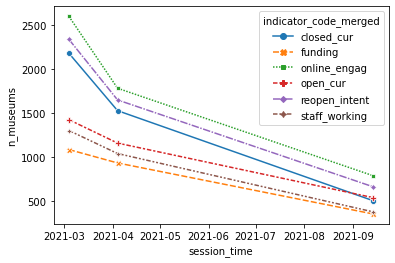

In [22]:
sns.lineplot(data=mus_indic_counts_df, x="session_time", y="n_museums", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")

<AxesSubplot:xlabel='session_time', ylabel='indic_museum_pc'>

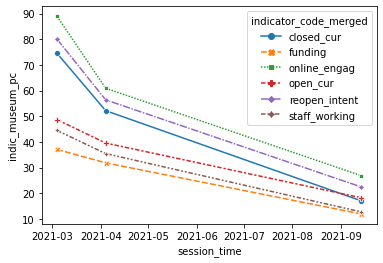

In [21]:
sns.lineplot(data=mus_indic_counts_df, x="session_time", y="indic_museum_pc", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")

End of notebook.